In [2]:
import numpy as np
import cupy as cp
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import normalized_mutual_info_score as nmi
import random as rn
from scipy.stats import norm
from sklearn.metrics import rand_score as rs
import matplotlib.pyplot as plt

# Code

In [22]:
from scipy.stats import norm
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt


def mydist(w,X, Y): ## Function to calculate the weighted distance between each points of the dataset
    dists = -2 * cp.dot(w*X, Y.T) + cp.sum(w*(Y**2),    axis=1) + cp.sum(w*(X**2), axis=1)[:, cp.newaxis]
    # if prob :
    dists[cp.where(dists <0)] = 0
    return dists

def lwk(dataset,num_clust,beta, nu,sigma,init_weights =None , init_mu = None, gamma = None) : 
    """
    Main OWL-k-means function

    Parameters:
    dataset : cupy array with dimension (number of data x dim)
    num_clust : number of clusters
    beta : power
    nu : penalty for lasso, should be positive
    sigma : penalty multiplier for OWL, should be positive.
    init_weights : initial weights
    init_mu : initial centers
    gamma : parameter to create OWL penalties suggested by Bogdan

    Returns: Tuple containing
    1. Cluster associaton (numpy array)
    2. Weights of each features (numpy array)
    3. Cluster centroids

    """
    numdata = dataset.shape[0]
    dim = dataset.shape[1]
    if gamma == None:
        q =0.1
        gamma_bh = norm.ppf(1-np.linspace(1,dim,dim)*q/(2*dim))[::-1]
        gamma = cp.array(gamma_bh)


    ## standardization
    dataset = ((dataset - cp.mean(dataset,axis =0)) * 1/cp.std(dataset,axis =0))

    # if initial weights and means are not given take weights to be uniform
    # and initialize centers from k means clusters having least total cost
    if init_weights is None :
        # k-means iteration
        from sklearn.cluster import KMeans
        mean_1 = 0 * np.ones((13))
        mean_2 = 300 * np.ones((13))

        weights = cp.array([1/dim for i in range(dim)]) 
        cost_last = cp.inf
        for _ in range(10):
            kmeans = KMeans(n_clusters=num_clust).fit(cp.asnumpy(dataset))
            asso_matrix = cp.zeros((numdata,num_clust))
            for c in range(num_clust):
                asso_matrix[np.where(kmeans.labels_ == c )[0],c] = 1

            mu_new = cp.array(kmeans.cluster_centers_)
            a = cp.zeros((dim))
            for clust in range(num_clust) :
                dist_clust = (dataset - mu_new[clust]) ** 2
                a_add = asso_matrix[:,clust] @ dist_clust
                a = a + a_add
            
            cost_new = cp.dot(weights**beta ,a)+ nu * cp.dot(cp.abs(weights) ,a) + cp.sum(sigma*gamma * cp.abs(cp.sort(weights)[::-1]))
            if cost_new < cost_last :
                mu = mu_new
                cost_last = cost_new      
            


        #weight initialization
        weights = cp.array([1/dim for i in range(dim)]) 
    else :
        weights = cp.array(init_weights)
        mu = cp.array(init_mu)

    cost_last = cp.inf
     
    for l in range(10) :
        # calculate u
        distmatrix = cp.zeros((numdata,num_clust))
        asso_matrix = cp.zeros((numdata,num_clust))
        distmatrix = mydist(weights**beta ,dataset,mu)
        min_array = cp.argmin(distmatrix,axis= 1)
        for i in range(numdata) :
            asso_matrix[i,min_array[i]] = 1
        # calculate z
        for clust in range(num_clust) :
            u_clust =asso_matrix[:,clust]
            mu[clust] = cp.zeros((dim))
            mu_data = dataset[cp.where(u_clust != 0)]
            mu[clust] = cp.mean(mu_data,axis=0)
        # claculate W
        a = cp.zeros((dim))
        for clust in range(num_clust) :
            dist_clust = (dataset - mu[clust]) ** 2
            a_add = asso_matrix[:,clust] @ dist_clust
            a = a + a_add
        #frank wolf loop
        numiter = 1000
        firstweight = np.zeros(numiter)
        lastweight = np.zeros(numiter)
        for wolf in range(numiter) :
            a_w = beta * a * (weights ** (beta-1)) + nu * a
            argw = cp.argsort(weights)
            argw = cp.argsort(argw)
            l_sorted = sigma * gamma[argw]

            a_w = a_w + l_sorted

            s = cp.zeros((dim))
            s[cp.argmin(a_w)] = 1
            alpha = 2/(wolf+numiter)
            weights = weights + (alpha * (s - weights))

            firstweight[wolf] = weights[0]
            lastweight[wolf] = weights[-1]

        # plt.plot(np.linspace(0,numiter,numiter),firstweight )
        # plt.show()
        # plt.plot(np.linspace(0,numiter,numiter),lastweight )
        # plt.show()


        # print("__________________________________________________________________________________________")


        weights[cp.isinf(weights)] = 0
        cost = cp.dot(weights**beta ,a)+ nu * cp.dot(cp.abs(weights) ,a) + cp.sum(sigma*gamma * cp.abs(cp.sort(weights)[::-1]))
        # print(cost)
        # plt.scatter(x = np.arange(dim), y= cp.asnumpy(weights))
        # plt.show()
        
        if cp.abs((cost - cost_last)/cost_last) <= 0.005:
            break
        cost_last = cost

        computed = cp.argmax(asso_matrix,axis = 1)
    return cp.asnumpy(computed),cp.asnumpy(weights), cp.asnumpy(mu)


# Simuation

In [14]:
def gendata():

    numdata = 200
    dim = 13
    sigma_1 = 10
    type_1_gene = np.random.multivariate_normal(np.zeros((5)), (sigma_1** 1) * np.identity((5)), size = 200)

    sigma_2 = 50
    type_2_gene = np.random.multivariate_normal(np.zeros((5)), (sigma_2 ** 1) * np.identity((5)), size = 200)



    all_gene = np.hstack((type_1_gene,type_2_gene))

    mean_1 = 0 * np.ones((10))
    mean_2 = 100 * np.ones((10))

    all_gene[0:100,:] = all_gene[0:100,:] + mean_2

    unimportant_gene = np.random.multivariate_normal(np.zeros((3)), (50 ** 1) * np.identity((3)), size = 200)
    all_gene = np.hstack((all_gene,unimportant_gene))

    label = np.hstack((np.zeros((100)),np.ones((100))))
    data = all_gene.copy()
    print(data)
    return data

In [15]:
label = np.hstack((np.zeros((100)),np.ones((100))))

[[ 9.77957390e+01  1.03274384e+02  9.67084691e+01 ... -2.58332579e-01
   7.55128619e+00  2.63942614e-01]
 [ 1.00561726e+02  1.03318913e+02  1.00873000e+02 ... -1.45153683e+00
   9.78809155e+00 -5.55205633e+00]
 [ 1.00279598e+02  9.65176422e+01  9.87359974e+01 ... -2.79469409e+00
  -1.84078768e+00  9.10720801e+00]
 ...
 [ 5.07936315e-01  1.34528604e+00 -1.29130846e+00 ...  5.06781266e+00
  -4.20417997e+00 -5.11337721e+00]
 [ 3.32099337e+00  1.46294878e-01  5.09790941e-01 ... -5.54625537e+00
  -1.90061795e+00  3.99014265e+00]
 [ 2.35833265e+00  3.21210645e-02  2.43054779e-01 ...  5.34493695e+00
   6.00052608e-02  1.09771855e+01]]


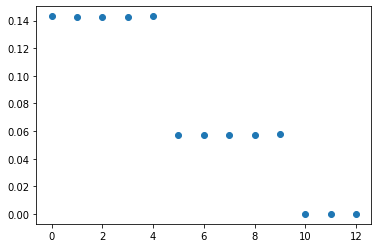

1.0
[[ 1.04225530e+02  9.49743015e+01  9.82513855e+01 ...  1.10715113e+01
  -8.78740747e+00 -1.76176910e+01]
 [ 1.01776755e+02  9.90524007e+01  9.59947786e+01 ... -3.34851124e+00
  -1.90917787e+01  8.56932283e+00]
 [ 1.01643752e+02  9.58840598e+01  9.58667772e+01 ...  1.25341941e+00
   1.39899682e+01  3.43894024e-01]
 ...
 [ 1.16643489e+00  6.08274174e-02 -9.41266825e-01 ...  2.62514897e+00
   2.47631612e+00  1.94795695e+00]
 [-2.11047110e+00  1.48615901e+00  2.89355643e-01 ...  5.24862524e+00
   1.15785253e+01  3.18851467e+00]
 [-5.11717556e+00 -5.78600579e-01  1.90992371e-01 ...  2.79964704e+00
  -1.50981563e+00 -1.64959706e+00]]


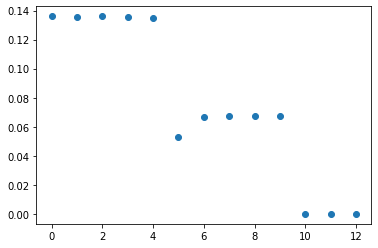

1.0
[[102.7922321  105.9942037   98.03249746 ...  -2.75843882  -7.03111123
  -11.12236194]
 [101.43111647 101.40357765 104.0200511  ...  -5.48165266  -2.4474021
    7.96421671]
 [101.33133363 100.45802095 101.52696029 ...  -5.99330429  -4.18583193
   -1.41863315]
 ...
 [  2.61910366  -7.6010083    1.70862935 ...   1.63001222   3.9836447
   -5.01970752]
 [ -1.79542157  -1.85464965  -0.65501128 ...  -6.54302541  -9.50183292
   -9.6537067 ]
 [ -3.99927545   3.86188979   1.85781638 ...   9.71123907 -10.11165458
   -2.58540384]]


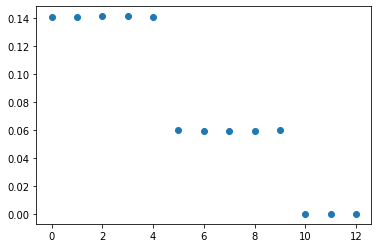

1.0
[[100.18608878 100.65802874  99.44397272 ...  -2.24305576  10.34656521
  -14.96430713]
 [102.8076748  101.07945687 102.49316494 ...   3.333703   -15.06568454
   10.1859007 ]
 [ 97.93811382 100.57954487 102.0291703  ...  -9.66872533  -9.27013344
   10.69704139]
 ...
 [  0.15114778  -0.30363317  -0.65828666 ...  -7.44036055   2.20045901
    4.59740563]
 [ -3.52572366  -3.00555704  -2.48808488 ...   9.91447289   6.16640268
    3.14171793]
 [  1.85703842  -0.29561968   1.0929509  ...  -8.23271635  -1.34382737
   -1.58594754]]


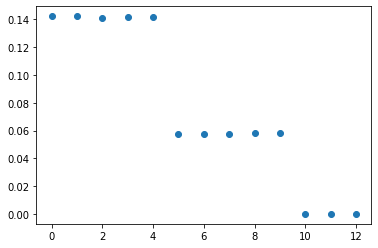

1.0
[[ 1.01462635e+02  1.02680886e+02  9.62305726e+01 ... -2.32634864e+00
   2.53172433e-01 -8.77880822e+00]
 [ 1.00782682e+02  1.03712292e+02  9.73628875e+01 ...  8.09796836e+00
  -9.37206276e+00  7.39623078e-02]
 [ 1.02388451e+02  9.90225239e+01  9.73739867e+01 ... -7.59356382e+00
  -1.09955466e+00 -2.85154724e+00]
 ...
 [-3.33319642e+00 -2.63687866e+00 -4.83903080e+00 ...  3.02239154e+00
   2.73642579e+00  5.94210182e+00]
 [-3.04440943e+00  2.46504074e+00  1.62749362e+00 ...  1.74135668e+00
  -5.92560642e+00  2.73303202e+00]
 [-5.77975873e+00 -1.97048439e+00 -2.52947734e+00 ... -1.64312116e+01
  -9.22726714e+00 -5.47566875e+00]]


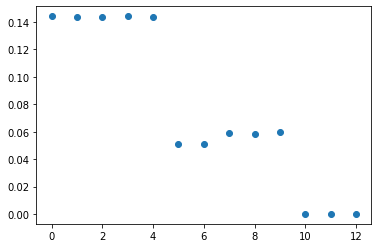

1.0
[[ 1.04762254e+02  1.00280056e+02  9.94149728e+01 ... -9.27414195e+00
   1.66888403e+00 -8.06437835e+00]
 [ 9.85916722e+01  9.75706658e+01  9.55881911e+01 ... -1.80480753e+00
  -1.11558870e-01 -8.28790742e-01]
 [ 1.01289654e+02  9.94665705e+01  9.96119652e+01 ... -4.71274081e+00
  -3.72325543e+00 -1.38265631e+00]
 ...
 [ 3.51042046e+00  3.48586426e+00 -3.95101155e-01 ... -1.40408779e+00
  -1.14600305e+00 -3.89396678e-02]
 [-1.45176634e+00 -3.67676267e+00 -2.03072470e+00 ... -5.81584562e-01
  -7.22575061e-01 -7.64865715e+00]
 [-9.93420180e-01  9.81299412e-01 -1.22576898e+00 ...  4.91607992e+00
   2.34349829e+00 -5.63046574e+00]]


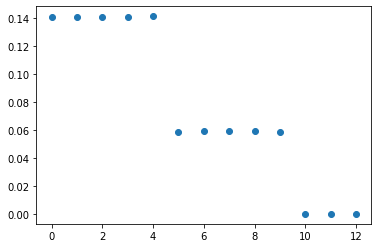

1.0
[[102.32486558 101.95848885  97.01742895 ... -14.13208814 -19.07586486
   22.26273045]
 [103.37281167  97.85885387 104.8248576  ...   5.00476711   5.05043297
  -11.69218995]
 [ 95.66618957 100.27701566  98.98594166 ...  -7.83133976   7.38400331
   -7.14858766]
 ...
 [ -3.92858021   2.70377303   4.71595011 ...   6.41947453  -1.10569756
    2.9441346 ]
 [ -2.10431324  -1.79690152  -3.08097539 ... -13.30073171   4.16832224
   -0.24991767]
 [ -4.35169743   1.95860463   4.47011909 ...   2.26379031   0.67698243
    1.63735139]]


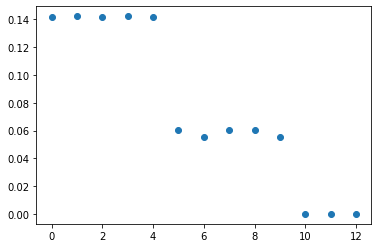

1.0
[[ 97.71011641 106.48327842  99.98326705 ... -10.98339098   2.89674562
    0.61398323]
 [ 96.0144125  105.30722021  96.68474807 ...  -1.15816244  -1.91384577
    8.36846038]
 [ 93.75810287 101.86870513  97.1747394  ...   5.41422625  10.31518341
   -9.78719808]
 ...
 [  3.73683496  -5.38847938  -4.00110109 ... -12.45037166 -10.83765184
    9.78449223]
 [  2.9358257   -4.74028388  -0.65985231 ...   1.17049156 -10.39725071
   -4.35190191]
 [  2.11913501   0.86092697   1.78586245 ...  -7.49452225  -2.94351649
   -9.31482514]]


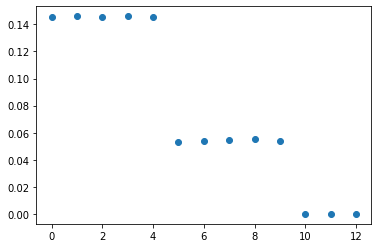

1.0
[[105.79919803  98.79902311 103.29841628 ...  -6.93316673  -8.17327905
    0.51875919]
 [ 99.60576065 105.13713055 108.93678418 ... -11.70139793  -5.04047985
    0.67573189]
 [101.96390442 106.3815799   99.47232854 ...  -4.64858756  -1.05463507
   -5.43249521]
 ...
 [ -1.40035459   2.60798262  -1.62738544 ...   8.57523231   2.1296069
   -0.70350928]
 [  2.09281327   4.9088329    3.87264336 ...  -5.44771695   1.07879
    9.77403703]
 [  1.52814055  -5.74007666   4.55514858 ...   8.91500865  -8.74221594
   -4.40353709]]


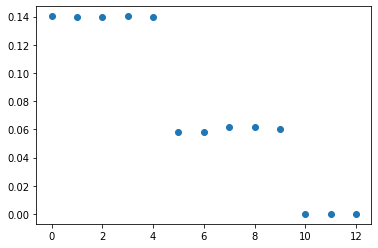

1.0
[[ 99.72242234  95.0545402  100.98628592 ...  -6.43394463  -3.62887068
   -2.95642849]
 [103.37497927  93.05378962 103.22138102 ...  -0.29759148  -8.65747924
    5.8956181 ]
 [ 90.81206162  96.42924564 103.09770158 ...  10.70602756  11.09419879
    5.56208486]
 ...
 [ -1.04761125  -1.54843604  -5.53291188 ...  -2.23527148  -7.46037026
   11.15712106]
 [ -1.2585706   -4.0921262   -4.52205502 ...   5.2689139    7.96318978
   -0.60258746]
 [  1.21759947   0.69288241   4.33679569 ...  -3.35970765  13.62832632
    6.25381903]]


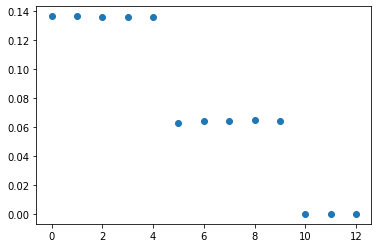

1.0
[[104.94247635 102.62786626 100.10736715 ...   3.24109714  -7.38807634
   -3.56797055]
 [ 98.84223677  99.07238269  97.82916423 ...   8.31572581  -3.40738548
   17.32092923]
 [103.47731678 103.59543782  95.64698594 ...   2.0171073    6.30490345
   -0.62315208]
 ...
 [ -0.16100343   4.62434976   1.3071021  ...   7.19061078   2.93613143
  -11.0475461 ]
 [ -0.15589656   1.37263807   0.3057983  ...  -9.05293149   0.11454244
    4.67434932]
 [  0.37299333   2.736825    -0.36766793 ...   8.18368036  -3.03759478
   -2.66273395]]


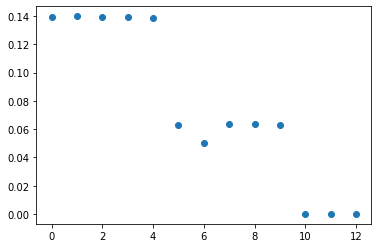

1.0
[[ 96.7054752   96.84590523  94.32531619 ...   8.75178397  -2.70342916
   -4.44046747]
 [101.97971866  96.44135122  95.75275313 ... -13.57374401   2.01289419
   -1.19648817]
 [ 95.09105985  97.44042669 100.41938745 ...  11.63192773   8.85707653
   -3.44229157]
 ...
 [  6.13817801  -1.30887221   0.76587485 ...  -2.5608273    9.7742714
    4.23023045]
 [  0.12768374  -1.84540783  -1.56768438 ...   4.53155185 -10.72720931
   -7.39047578]
 [ -1.22487712  -6.1462466    5.60692752 ...   0.90254693  -9.30145876
    0.81108207]]


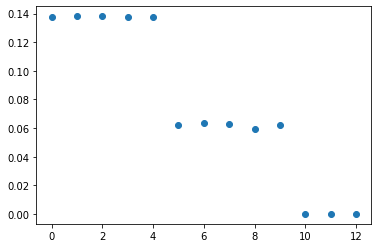

1.0
[[101.28723041 103.59844842 105.15236972 ...  -7.93265251  -5.16304008
   -1.09328379]
 [ 93.99433673 102.49957917 103.14904178 ... -14.40432716 -12.54221737
    2.0253297 ]
 [ 96.76721314 100.65935292  96.94554006 ...   6.96396105   6.33512627
    1.70435186]
 ...
 [  1.73590542  -1.69486568   1.88773575 ...   4.33929934   4.48356963
   -2.05493531]
 [ -2.72631997  -2.87686579  -1.97993709 ...  -8.99621245   5.9982928
    3.63142069]
 [  4.87196756  -2.99038161  -2.82326777 ...  -7.6964514    9.1346998
   -8.78833854]]


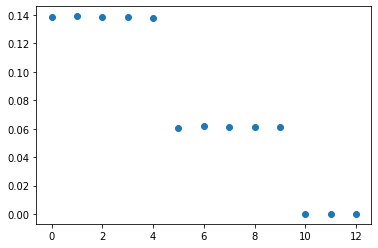

1.0
[[101.82613824  99.05549855  99.39735483 ...   9.06632493  -5.78975709
   -0.11157749]
 [104.20052953 103.19426395  97.7734666  ...  -3.06070009  -8.36997895
   -4.36990936]
 [101.49666305 101.03508635  99.76483935 ...  -2.49788854   0.65470997
    3.05095055]
 ...
 [  0.75319751   3.42846698  -0.71440786 ...   6.76939115  11.20978003
  -12.68666268]
 [ -3.54952767  -0.11386107   4.25488068 ...   6.95928741   4.74241248
   -1.17782024]
 [  1.59273364   2.08633183  -1.46304236 ...   1.73689392   2.19013242
    4.41157389]]


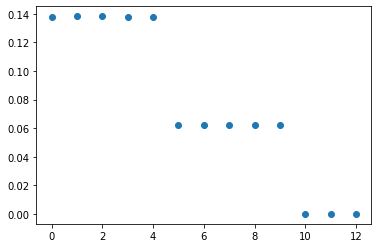

1.0
[[ 9.39002439e+01  1.04864297e+02  9.90987967e+01 ...  6.51558190e+00
   5.96447429e-02 -5.17036194e+00]
 [ 1.05290489e+02  1.03475468e+02  1.00643761e+02 ... -1.02801910e+00
  -2.74443634e+00 -6.39698658e+00]
 [ 1.03761965e+02  9.82258156e+01  1.02777137e+02 ... -6.61054622e+00
  -2.65178856e+00 -1.76698333e+00]
 ...
 [-2.38930019e+00 -1.00754596e+01  2.09211852e-01 ...  1.11546210e+01
   1.51128752e+01  5.47224940e+00]
 [ 3.51781095e+00  3.38199254e+00  3.37656213e+00 ...  1.19091771e+01
   2.16664710e+00 -9.26440898e+00]
 [ 3.88310167e+00 -6.32557552e-01  1.26457237e-01 ...  1.68615644e+00
  -2.14756043e+00 -3.81606092e-01]]


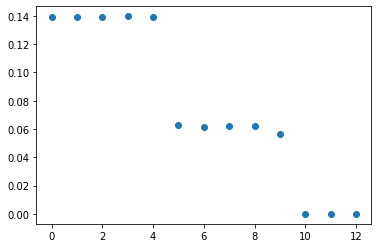

1.0
[[101.91509766  98.85831171  98.25147876 ...   7.9555258    0.56341641
   -8.9343099 ]
 [ 98.70985298 102.31612753  95.07906652 ...  -9.12386436   2.92781161
    3.08083189]
 [104.11967573  96.76413532  99.37501052 ...  -1.01270733 -10.79368122
    1.21510135]
 ...
 [  4.85508891  -1.2900026    4.29819109 ...  -0.21342101 -10.0956202
   -4.93940347]
 [  2.26484889   5.63462462  -8.11711044 ...  -2.41117673 -14.08266695
    1.14864726]
 [ -4.42173339   0.8259334   -2.33143035 ...   5.60822333   1.05721034
    1.34348083]]


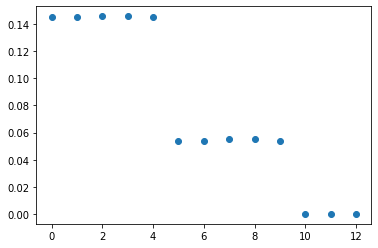

1.0
[[103.78654306 100.98358558  99.36490279 ...   5.26987346   9.3951206
   10.19225367]
 [103.12113985  97.46786892  95.42854409 ...   1.55920667   0.59331504
   -4.03991138]
 [ 95.75778103  93.07015659  96.98172859 ...   1.58743085  -5.2527137
   -4.58786999]
 ...
 [  5.41969822   0.3619399   -6.2867792  ...  -6.87436448  -6.74755563
    4.25071114]
 [ -2.00003784  -1.77814096  -3.76707248 ...  -3.79351391  -6.93386276
   17.2641677 ]
 [ -2.37889768   0.75339122  -3.38007196 ...  -3.37543331   9.48859554
   -2.99206648]]


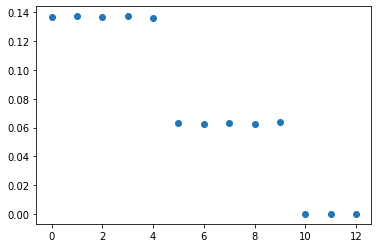

1.0
[[103.22428485  99.54711249 100.42864306 ...  -5.89290319   7.29122072
    4.39442368]
 [100.00474036 102.66749944  96.00225587 ...   6.77319779  -7.9319172
   -1.71308827]
 [ 97.52955026  95.6480384  102.86054681 ...  -0.15574432   7.79861209
   -8.19147078]
 ...
 [ -6.40614875  -5.03811812  -5.12882189 ...   0.7705058   -5.77261673
   -2.74453231]
 [  1.14459749   6.2838542    1.14799803 ...  10.18179797   2.53257026
  -10.27753743]
 [  4.92876502  -1.53178777   1.12218599 ...  -1.11307135   9.27614821
    7.03672763]]


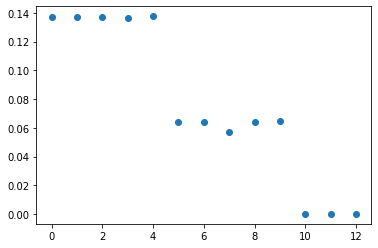

1.0
[[100.26064588  96.62184431  98.30717632 ...   4.53753604   6.27129622
    0.6705137 ]
 [105.09506875  96.05647273  98.70011547 ...  13.49324776 -10.55539473
    8.18397752]
 [ 93.99572498 104.0871342  100.00320155 ...  -0.43705717   6.21144533
    8.0790819 ]
 ...
 [  2.89118157   2.86787218  -2.14140669 ...  -0.830621    -1.13973628
    2.60233553]
 [ -3.86065306   9.00980359   0.66594719 ...   8.60272391  -8.27481653
    2.95269375]
 [ -1.3899464    3.32726076  -1.02306053 ...  -1.56962267  -7.11293476
   -4.18732707]]


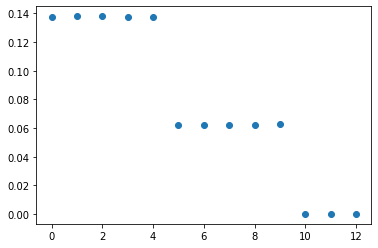

1.0
[[102.79575722  98.32213255  95.68985541 ...  -6.98877586   4.66923476
  -13.67508818]
 [102.77522277  98.84140156  98.90452804 ...   6.87050963  -5.94498286
   -3.56406438]
 [ 96.62235548 104.36378588 101.21560229 ...  -4.5059943  -11.21268029
   -4.87423593]
 ...
 [  1.71375657  -1.52903587  -3.07404079 ... -15.15625072   0.75038541
    4.10902579]
 [ -6.16153956  -0.82262004  -7.046353   ...  -7.80255607   3.23212472
   -4.80936498]
 [ -4.52513505   0.12246222  -0.81571533 ...   2.77615062 -17.48401351
  -10.06812247]]


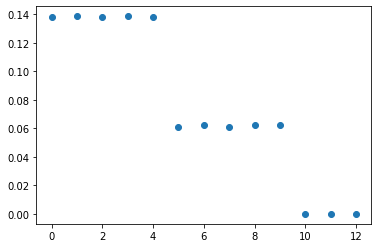

1.0
[[ 1.04219037e+02  1.01955161e+02  9.90196387e+01 ...  5.42916749e+00
   4.23466522e-01 -1.65292565e+00]
 [ 1.02196450e+02  9.98115367e+01  9.92026160e+01 ...  3.99491498e+00
  -4.23043662e-03 -2.73296035e+00]
 [ 9.88435556e+01  9.88088693e+01  1.00108174e+02 ... -7.63851708e-01
   2.10059854e+00  6.33957573e-01]
 ...
 [ 6.35086342e+00  5.07000131e+00  5.19128940e+00 ... -1.15230555e+01
  -7.37937723e+00  4.63982028e+00]
 [ 4.51865088e+00  7.60597045e+00  4.00670053e+00 ... -8.65000284e-02
   1.19970975e+01 -3.25819522e+00]
 [-1.74391330e+00 -3.23264459e+00  1.09837468e+00 ... -3.18503821e+00
  -4.81945166e+00  4.83975258e+00]]


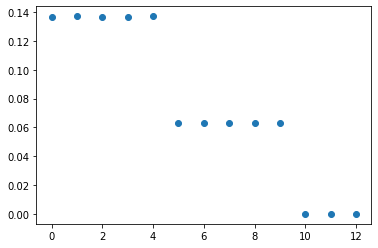

1.0
[[ 9.28679391e+01  9.57642208e+01  1.07214812e+02 ...  1.65258336e+01
   1.06971195e+00  6.08967716e+00]
 [ 1.02937584e+02  9.52625161e+01  1.04407795e+02 ...  1.62269895e+01
   1.47015526e+00 -1.08269480e+01]
 [ 9.64633924e+01  1.05155131e+02  1.06741154e+02 ...  5.34066732e-01
   2.45194920e+00  9.57801649e+00]
 ...
 [ 2.67604330e+00  1.28915409e+00  2.30218526e+00 ... -2.47531026e-01
  -7.55183476e+00  6.23730334e+00]
 [ 6.18209047e-01 -1.07492800e+00  8.80419790e+00 ...  1.19632057e+01
  -1.26387845e+01  1.07234291e+01]
 [ 2.29542274e+00 -1.27713057e+00 -3.93295698e-01 ...  1.00034588e-01
   4.39891960e+00  8.99656151e+00]]


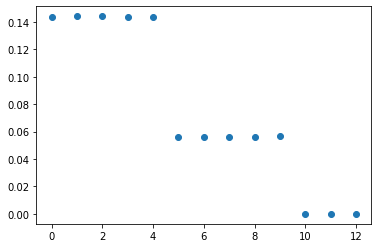

1.0
[[ 98.81824799  97.52261364  98.80498343 ...  -1.44348097  -5.18293497
  -11.11271893]
 [107.09113411  96.97250382  98.55601698 ...  -2.13511504  10.74222895
   -2.59027587]
 [ 98.75887597  97.48886369 102.83202893 ...  -1.61766234   8.23990254
   -6.86728626]
 ...
 [ -4.3405289   -0.13658826   0.63266673 ...   4.21486689   6.74275159
   -3.28321451]
 [  0.15351666   2.62653305  -3.68864557 ...  -8.78499338   0.89087506
    0.18360992]
 [  0.92036615  -1.14672208  -0.50980558 ...  10.13571545   2.06602365
    2.42148471]]


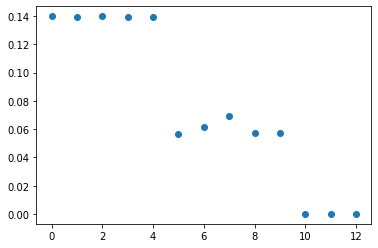

1.0
[[102.56655173  96.51208924 102.51548159 ...   4.13454745   2.14212666
   -8.24912603]
 [102.35646658  95.71819447  92.01872791 ...   2.99378689  -5.27378764
    4.53238234]
 [ 98.09865672  99.88692897  93.55516573 ...  -1.14593233  -3.95734068
   -3.67773064]
 ...
 [ -3.00503718  -2.34179577  -4.41358738 ...  -2.08151001   4.77956219
    1.81262524]
 [ -2.33197348  -5.92667818   3.22576939 ...  16.63790981   1.74560124
   -7.56350441]
 [ -1.88405027   2.38714268  -5.22506926 ...  -3.8933646    2.35431109
    0.35405041]]


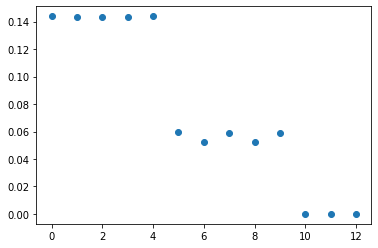

1.0
[[102.18201145 101.37148334 100.94041816 ...  -3.81133087   9.62776483
   -4.60635398]
 [100.07534422  96.7275562   96.16985749 ...  -7.98886706  -8.59448828
   17.95779442]
 [ 95.87513895  94.38212601  96.77496516 ...   1.6469837    3.50930667
    0.57035808]
 ...
 [  0.65744861  -2.95478832  -0.94324433 ... -11.01746516   5.62134969
   -7.80749393]
 [ -1.35836982  -5.01299256  -0.35448571 ...  -0.20215609 -12.36673795
   -3.05736277]
 [  3.84075762   2.41257656  -1.47062236 ...  -4.17891817  12.83353929
   -9.35223974]]


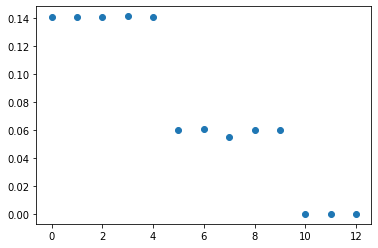

1.0
[[ 9.68839658e+01  1.08473018e+02  1.04447581e+02 ... -1.00546557e+01
  -2.30916352e+00 -9.39565097e+00]
 [ 1.03629336e+02  9.89523604e+01  1.00768431e+02 ... -5.41687270e+00
  -7.80560948e+00 -2.30101465e+00]
 [ 9.51624562e+01  1.02830005e+02  1.01227715e+02 ...  8.88150410e+00
   1.25051804e+01 -1.31685057e+01]
 ...
 [ 5.25735938e+00 -5.35149736e+00 -1.40172609e+00 ...  1.02757239e+01
  -1.48448674e+00  5.81771767e-01]
 [-4.19610246e+00 -6.50564896e-02 -1.39690446e+00 ... -1.18659153e+01
  -5.55461340e+00 -2.75997489e+00]
 [ 3.11429455e+00 -1.95280925e+00  8.41444970e-01 ...  1.54762381e+01
  -1.49875174e+00  1.09277872e+01]]


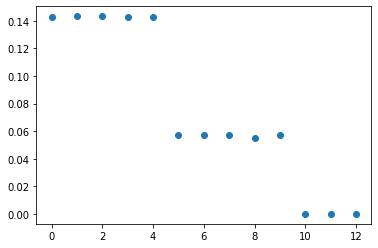

1.0
[[ 1.00594378e+02  1.04080037e+02  9.90308299e+01 ...  4.41655311e+00
  -1.43616981e+00  1.04426023e+00]
 [ 9.26338760e+01  9.13729705e+01  1.03040551e+02 ... -1.22484643e+01
   7.96908458e+00 -8.64907109e+00]
 [ 1.00140450e+02  9.56442811e+01  1.02159384e+02 ... -1.14846558e+00
  -1.15301944e+01  4.95049033e+00]
 ...
 [ 3.23015771e+00 -1.11915379e+00 -5.65132779e-01 ...  1.77703110e+01
  -1.16796349e+00 -3.43272547e+00]
 [-7.46701252e-02  1.70913312e+00 -5.31768907e+00 ... -3.88255959e-02
  -1.23983443e+01  2.24278631e+00]
 [-1.58250811e+00 -8.71283187e+00  2.16700036e+00 ...  3.83443588e+00
   4.97871299e+00  9.56470242e-01]]


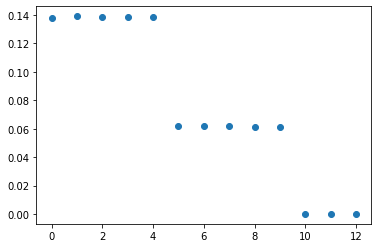

1.0
[[ 92.01574216 101.23691864  99.17978025 ...  10.78168383  -1.95644621
  -13.38188088]
 [105.9706807   99.46106779  99.56392875 ...  -6.26854546 -11.38114807
    3.24474   ]
 [102.40971707  99.53021802  98.06271281 ...   2.95335141  -9.76618799
    4.4348748 ]
 ...
 [ -1.28411306  -2.47969989  -1.29623642 ...  -7.48997202   9.60226617
   -1.97806615]
 [ -0.4748231   -2.5149427   -1.46542575 ...  -1.23427004  -1.44029023
    3.5164147 ]
 [  3.42743054   3.52856723  -3.12092525 ...  -4.03638116  -6.51559317
   10.89849275]]


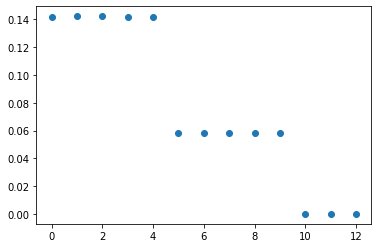

1.0
[[ 96.71183458 102.04499758  98.44068891 ...   7.7361511    0.81749902
    2.58649617]
 [100.68402218  99.53940427  94.11933542 ...   5.70117721  -3.88708393
    6.2006304 ]
 [ 98.6625553  101.62655744 101.28676321 ...  11.65175064 -10.24660332
    2.48308708]
 ...
 [ -1.17664034  -0.85370373   3.51941325 ...  -2.59709312  -6.9811627
    0.17402714]
 [  3.03634134  -1.75552065  -5.63149229 ...  -3.25082969   3.86360697
    4.62094444]
 [ -0.15450191   0.28464884  -4.43084279 ...  14.60249095   0.89576711
    2.1878516 ]]


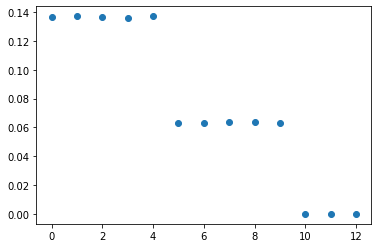

1.0
[[ 9.96660767e+01  9.69820575e+01  9.91631582e+01 ... -9.02000441e+00
  -5.43243586e+00  1.48932072e+00]
 [ 9.74145503e+01  1.04618704e+02  9.94771878e+01 ... -2.22915516e+00
  -8.40872626e-01 -6.08331525e+00]
 [ 1.01677309e+02  9.76883351e+01  9.77755478e+01 ...  1.10796092e-01
  -1.03008780e-01  4.80012025e+00]
 ...
 [-5.16231707e-01 -5.01695240e-01  2.87986763e-01 ... -3.45545811e+00
   2.84750958e-01  6.93932322e+00]
 [ 1.40143912e-01  6.15659175e-01  7.72248179e-01 ... -5.96652849e+00
   3.33010330e+00  1.10887353e+01]
 [-4.25101984e+00  3.91916218e+00 -1.46186899e+00 ... -1.36589644e+01
  -1.08809251e+01 -2.39185730e+00]]


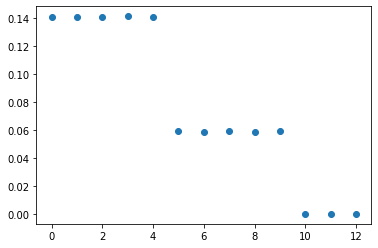

1.0


In [23]:
all_weights = np.zeros((30,13)) # next one is dim
for i in range(30) :
    data = gendata()
    computed, pweight,pmu = lwk(cp.array(data), num_clust = 2,beta = 4,nu=0,sigma=0)
    computed, lweight,_ = lwk(cp.array(data),num_clust = 2,beta = 4,nu=0.004,sigma=0.025,init_mu = pmu, init_weights = pweight)
    # print(lweight)
    plt.scatter(x=np.arange(13),y=lweight)
    plt.show()
    print(ari(computed,label))
    all_weights[i] = lweight

# Plots

In [24]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Avarage Feature Weights')

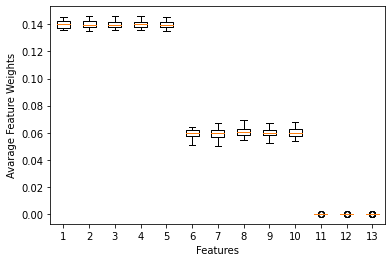

In [25]:
plt.boxplot(all_weights)
plt.xlabel("Features")
plt.ylabel("Avarage Feature Weights")

Text(0, 0.5, 'Feature Weights')

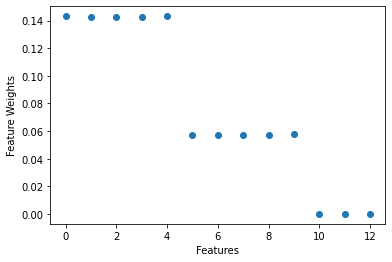

In [28]:
plt.scatter(x=np.arange(13),y=all_weights[0])
plt.xlabel("Features")
plt.ylabel("Feature Weights")